In [1]:
# Importar bibliotecas
import pandas as pd
import numpy as np

import datetime
import numpy.random as rnd

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import seaborn as sns

import yfinance as yf

from forex_python.converter import CurrencyRates
from pandas_datareader import data as DataStock

In [2]:
# Algoritmo:
#     Cargar data de una serie de activos financieros, clasificados por tipo y riesgo (alto, bajo, medio)
#     Tomar un X de fondos y repartirlo entre las tres categorías (determinar el % de cada una en uno de los inputs)
#     En cada categoría, repartir todo en boxes uniformes, mismo monto para cada item
#     Dejar un resto como liquidez mínima (10% del total)
#     Por un período de tiempo y, correr en cada día:
#         Correr función de stop loss:
#             Revisar todo el portfolio, si la perdida en un box supera el stop loss, liquidar
#         Correr funcion de cash out
#             Revisar todo el portfolio, si la ganancia en un box supera el cash out, liquidar
#         Determinar un numero random de operaciones de venta a ejecutar
#         Correr ventas, generar liquidez
#         Correr compras, consumir liquidez, adquirir cada activo por un monto A (buy in parameter)
#         Correr comparativa vs indices, otros ETF
#     Llegar al final del tiempo, liqiudar inventario, calcular ganancia

In [3]:
# Marco temporal

In [4]:
data_start_date = '2015-01-01'
data_end_date = '2021-10-15'
# end_date = datetime.datetime.now().strftime('%Y%m%d')

In [5]:
# Data de tickers

In [6]:
tickers_ARG = '^MERV ALUA.BA CEPU.BA COME.BA PAMP.BA GGAL.BA TRAN.BA YPFD.BA'
currency_ARG = 'ARS'
tickers_BRA = '^BVSP'
currency_BRA = 'BRL'
tickers_NASDAQ = '^IXIC AMAT AAPL ADC AE AFB AMZN BAC BMO BP BX CAT CNI COF COP CP CSCO CSX CPIX CVS DE DIS EL GM GE GOOG GSK HD HON HSBC HYT INTC ICU IRM ISRG \
                JNJ JPM KAMN KFFB KMB LECO LIN LMT MA MCD MELI MET MMM MRVL MSFT MSI NVDA NFLX NKE OEC OEG PAI PBR PFE PG PPSI RBLX RIO RMTI SBUX SNAX TCBC TMO \
                TRI TXN UPS UNH VALE WFC WMT WRAP WU XOM V Y ZY'
currency_NASDAQ = 'USD'
tickers_DOW = '^DJI AXP BA GE GS IBM WMT DOW CAT'
currency_DOW = 'USD'
tickers_DOW = '^FTSE'
currency_DOW = 'GBP'

In [7]:
# Data de FOREX

In [8]:
data_ARG = yf.download(tickers_ARG, start = data_start_date, end = data_end_date)

[*********************100%***********************]  8 of 8 completed


In [9]:
data_NASDAQ = yf.download(tickers_NASDAQ, start = data_start_date, end = data_end_date)

[*********************100%***********************]  81 of 81 completed


In [10]:
data_NASDAQ.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1709 entries, 2015-01-02 to 2021-10-14
Columns: 486 entries, ('Adj Close', 'AAPL') to ('Volume', '^IXIC')
dtypes: float64(414), int64(72)
memory usage: 6.3 MB


In [11]:
data_NASDAQ.replace(to_replace = np.NaN, value = -1, inplace = True);

In [12]:
# Preparacion de datos

In [13]:
data = data_NASDAQ['Open'].copy()
data_NASDAQ_INDEX = data['^IXIC'].copy()
data_NASDAQ_INDEX = pd.DataFrame(data = data_NASDAQ_INDEX.values, index = data_NASDAQ.index, columns = ['VALUE'])
data.drop(columns = '^IXIC', inplace = True)
data.head(10)

,AAPL,ADC,AE,AFB,AMAT,AMZN,BAC,BMO,BP,BX,...,UPS,V,VALE,WFC,WMT,WRAP,WU,XOM,Y,ZY
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,27.847500,31.260000,48.680000,13.77,24.990000,312.579987,17.990000,70.650002,38.209999,33.980000,...,111.269997,65.845001,8.02,55.110001,86.269997,-1.0,18.040001,92.250000,465.510010,-1.0
2015-01-05,27.072500,31.410000,49.299999,13.73,24.750000,307.010010,17.790001,69.699997,36.590000,33.880001,...,109.989998,65.872498,7.63,54.139999,85.720001,-1.0,17.840000,92.099998,458.600006,-1.0
2015-01-06,26.635000,31.990000,49.090000,13.86,24.129999,302.239990,17.420000,68.169998,36.009998,33.709999,...,108.169998,64.947502,7.98,53.349998,85.980003,-1.0,17.730000,90.239998,453.809998,-1.0
2015-01-07,26.799999,32.220001,49.389999,13.88,23.370001,297.500000,17.139999,67.470001,36.000000,33.299999,...,108.260002,64.610001,8.39,52.630001,86.779999,-1.0,17.860001,90.650002,452.160004,-1.0
2015-01-08,27.307501,32.740002,50.990002,13.86,23.690001,300.320007,17.160000,67.599998,36.430000,33.799999,...,109.290001,65.800003,8.35,53.000000,89.209999,-1.0,17.709999,91.250000,455.359985,-1.0
2015-01-09,28.167500,32.459999,52.150002,13.87,24.100000,301.480011,17.379999,67.070000,36.759998,33.810001,...,110.430000,65.902496,8.56,53.540001,90.320000,-1.0,17.910000,92.300003,454.980011,-1.0
2015-01-12,28.150000,32.169998,52.130001,13.93,24.270000,297.559998,17.020000,65.570000,36.189999,34.299999,...,109.919998,65.260002,8.35,52.580002,89.360001,-1.0,17.940001,91.239998,454.739990,-1.0
2015-01-13,27.857500,32.200001,52.580002,13.97,23.900000,297.480011,16.820000,64.790001,36.200001,34.720001,...,110.489998,65.504997,8.63,52.299999,90.800003,-1.0,17.950001,90.879997,456.500000,-1.0
2015-01-14,27.260000,31.910000,50.000000,13.99,23.010000,291.929993,16.000000,63.279999,35.160000,33.700001,...,109.019997,64.160004,8.21,51.000000,87.650002,-1.0,17.490000,88.949997,443.750000,-1.0


In [14]:
# Lista de las fechas sobre las cuales iterar

list_dates = data.index.tolist().copy()

In [284]:
list_dates[-400]

Timestamp('2020-03-17 00:00:00')

In [143]:
# Crear portfolio y llenarlo de tickers selecionados al azar
# Darle a cada unidad una personalidad (pasivo, activo, normal) y que se comporten de manera distinta; pasivos que solo actune frente a señales de corte; activos
# que tengan tasa de operacion acelerada y sean los que busquena las señales del mercado; actualizen la matriz de preferencia

def create_portfolio(total_boxes, start_date, cash_available_start):
    quota = cash_available_start / total_boxes
    portfolio = []

    rng = rnd.default_rng()

    for i in range(0, total_boxes):
        while True:
            box_ticker = rng.choice(a = data.columns.tolist(), replace = False)
            box_price = data.loc[start_date, box_ticker]
            if box_price != -1:
                break
        box_vol = quota / box_price
        box = pd.Series(data = [box_ticker, box_vol, box_price, 0, 0, 0], index = ['Ticker', 'Quant', 'Purchase_price', 'last_trade_result', 'last_free_cash', 'last_cash_gen'])
        portfolio.append(box)
    portfolio = pd.DataFrame(data = portfolio, columns = ['Ticker', 'Quant', 'Purchase_price', 'last_trade_result', 'last_free_cash', 'last_cash_gen'])
    return portfolio

In [144]:
# Valuacion de liquidacion del portfolio

def valuate_portfolio(portfolio, data, date):
    total_value = 0
    total_boxes = portfolio.shape[0]
    
    for i in range(0, total_boxes):
        box_ticker = portfolio.loc[i, 'Ticker']
        box_price_current = data.loc[date, box_ticker]
        box_value = portfolio.loc[i, 'Quant'] * box_price_current
        total_value += box_value
    
    return total_value

In [145]:
# Matriz de preferencia por cada ticker

# Probabilidad de elegir = preferencia normalizada
# Preferencia = valor generado histórico c/tasa de decrecimiento exponencial
# Tickers que generaron pérdidas tienen menos preferencia que los que generan ganancias; el efecto se diluye con el tiempo
# hiperparametro: tasa de memoria


In [146]:
# Depreciación exponencial de la matriz de preferencia

def ticker_weight_decay(ticker_weight, ticker_timer, memory_rate, date, prev_date):

    if date == ticker_weight.index[0]:
        return ticker_weight
    # Funcion de decaimiento exponencial para amortiguar el efecto de la historia
    ticker_weight.loc[pd.Timestamp(date), :] = 1 + ticker_weight.loc[pd.Timestamp(prev_date), :] / (np.exp(memory_rate * ticker_timer.loc[pd.Timestamp(prev_date), :]))

    return ticker_weight 

In [147]:
# Valuación de la celda

def valuate_box(portfolio, data, box, date):
    
    box_ticker = portfolio.iloc[box]['Ticker'] 
    price_sale = data.loc[pd.Timestamp(date), box_ticker]  
    value_sale = portfolio.iloc[box]['Quant'] * price_sale
    value_purchase = portfolio.iloc[box]['Quant'] * portfolio.iloc[box]['Purchase_price']
    trade_result = (value_sale - value_purchase) / value_purchase

    return trade_result, value_sale

In [148]:
# Compra/venta de una celda, ajuste de matriz de preferencia y temporizadora, actualización del disponible

def execute_trade(box, portfolio, data, ticker_proba_scaled, date, reinvest_rate):
    
    rng = rnd.default_rng()
    # Selección del ticker a operar
    local_box = box.copy()
    box_ticker = local_box['Ticker']
    #print('box index/name', box.name)
    # Calcular el valor presente del box a vender
    #print('Date:', date)
    #print('Sell:', box_ticker, '@', round(data.loc[pd.Timestamp(date), box_ticker], 3))
    #print(box_ticker, 'bought @', round(local_box['Purchase_price'], 3))
    trade_result, cash_gen = valuate_box(portfolio, data, local_box.name, date)
    # Sumo el cash generado, recalculo tamaño box y adjudico saldo
    if trade_result > reinvest_rate:
        quota = cash_gen * (trade_result - reinvest_rate)
    else:
        quota = cash_gen 
    # Reiniciar el timer del ticker

    # Selecciono una acción que esté en operación
    #print('Cash from sale:', round(cash_gen, 3))
    #print('Trade result:', round(100 * trade_result, 3), '%')
    while True:
        box_ticker = rng.choice(a = data.columns.tolist(), p = ticker_proba_scaled, axis = 0)
        local_box['Purchase_price'] = data.loc[pd.Timestamp(date), box_ticker]
        if local_box['Purchase_price'] != -1:
            break
    # Carga del nuevo box al portfolio
    local_box['Ticker'] = box_ticker
    box_vol = quota / local_box['Purchase_price']
    local_box['Quant'] = box_vol
    local_box['last_trade_result'] = trade_result
    local_box['last_cash_gen'] = cash_gen
    local_box['last_free_cash'] = cash_gen - quota
    #print('Buy:', box_ticker, '@', round(local_box['Purchase_price'], 3))
    #print('------------------')
    
    return local_box

In [247]:
# Función principal, corrida del portfolio en un rango temporal

def main(list_dates, start_date, start_portfolio, cash_min, trade_fee, memory_rate, reinforce_rate, cash_out, stop_loss,\
         daily_trade_min, daily_trade_max, reinvest_rate):
    # Tablas locales
    ticker_weight = pd.DataFrame(data = 0, index = list_dates[(list_dates.index(pd.Timestamp(start_date))): ], columns = data.columns)
    ticker_timer = pd.DataFrame(data = 0, index = list_dates[(list_dates.index(pd.Timestamp(start_date))): ], columns = data.columns)
    portfolio = start_portfolio.copy()
    
    rng = rnd.default_rng()
    
    # Variables locales
    stop_loss_rate = -1 / stop_loss
    total_boxes = portfolio.shape[0]
    prev_date = start_date
    run_portfolio_value = []
    cash_available = cash_min
    fee_income = 0
    
    #print('Cash at start:', cash_available)
    
    for date in list_dates[(list_dates.index(pd.Timestamp(start_date)) + 1 ): ]:
        # tomar daily_trade cajas al azar, liquidarlas y crear nuevas
        daily_trade = 0
        #print(portfolio)
        #print('fees:', fee_income)
        # Avanzar temporizador
        if start_date != date:
            ticker_timer.loc[date, :] = 1 + ticker_timer.loc[prev_date, :]
    
        # Recalcular matriz de probabilidades para la fecha
        ticker_weight = ticker_weight_decay(ticker_weight, ticker_timer, memory_rate, date, prev_date)
        ticker_proba = ticker_weight.loc[pd.Timestamp(date), :].copy()
        
        ticker_proba_scaled = (ticker_proba + np.abs(ticker_proba.min(axis = 0))) / (ticker_proba.max(axis=0) + np.abs(ticker_proba.min(axis = 0)))
        ticker_proba_scaled.replace(np.NaN, 0, inplace = True)
        ticker_proba_scaled.clip(lower = 0.0001, inplace = True)

        # Armar vector con las probabilidades de cada ticker escalados en 0,1
        ticker_proba_scaled = ticker_proba_scaled / ticker_proba_scaled.sum()
        #print('-------------')
        #print(ticker_proba_scaled*100)
        #print(ticker_proba_scaled.sum())
        #print('-------------')
        
        # Verificar que ninguna acción en uso haya sido deslistada, si paso, sacarla del portfolio
        for box in range(total_boxes):
            box_ticker = portfolio.loc[box]['Ticker']
            price_sale = data.loc[pd.Timestamp(date), box_ticker]
            if price_sale == -1:
                portfolio.loc[box] = execute_trade(portfolio.loc[box], portfolio, data, ticker_proba_scaled, date, reinvest_rate)
                # Pago de tasas de operacion
                fee_payment = portfolio.at[box, 'last_cash_gen'] * trade_fee
                fee_income += fee_payment
                cash_available += portfolio.at[box, 'last_free_cash']
                cash_available -= fee_payment
                
                # Reiniciar contador de tiempo
                ticker_timer.loc[pd.Timestamp(date), box_ticker] = 1
                # Cargar el resultado de la operación a la matriz de probabilidades/valoracion de tickers
                ticker_weight.loc[pd.Timestamp(date), box_ticker] += portfolio.iloc[box]['last_trade_result'] * reinforce_rate
                
                daily_trade -= 1
        
        # Verificar que ninguna acción pase el umbral de ganancia tolerado para hacer el cash out o para hacer el stop loss
        for box in range(total_boxes):
            box_ticker = portfolio.loc[box]['Ticker']
            trade_result, value_sale = valuate_box(portfolio, data, box, date)
            if trade_result > cash_out:
                portfolio.loc[box] = execute_trade(portfolio.loc[box], portfolio, data, ticker_proba_scaled, date, reinvest_rate)
                
                # Pago de tasas de operacion
                fee_payment = portfolio.at[box, 'last_cash_gen'] * trade_fee
                fee_income += fee_payment
                cash_available += portfolio.at[box, 'last_free_cash']
                cash_available -= fee_payment

                #print('-------------')
                #print('cash available:', cash_available)
                #print('-------------')
                
                # Reiniciar contador de tiempo
                ticker_timer.loc[pd.Timestamp(date), box_ticker] = 1
                # Cargar el resultado de la operación a la matriz de probabilidades/valoracion de tickers
                ticker_weight.loc[pd.Timestamp(date), box_ticker] += portfolio.iloc[box]['last_trade_result'] * reinforce_rate
                
                daily_trade -= 1
            elif trade_result < stop_loss_rate:
                portfolio.loc[box] = execute_trade(portfolio.loc[box], portfolio, data, ticker_proba_scaled, date, reinvest_rate)
                # Pago de tasas de operacion
                fee_payment = portfolio.at[box, 'last_cash_gen'] * trade_fee
                fee_income += fee_payment
                cash_available += portfolio.at[box, 'last_free_cash']
                cash_available -= fee_payment
 
                #print('-------------')
                #print('cash available:', cash_available)
                #print('-------------')
                # Reiniciar contador de tiempo
                ticker_timer.loc[pd.Timestamp(date), box_ticker] = 1
                # Cargar el resultado de la operación a la matriz de probabilidades/valoracion de tickers
                ticker_weight.loc[pd.Timestamp(date), box_ticker] += portfolio.loc[box]['last_trade_result'] * reinforce_rate
                
                daily_trade -= 1
 
        # Numero de cajas a operar por dia
        daily_trade += rnd.randint(low = daily_trade_min, high = daily_trade_max)
        # Crorrer las operaciones seteadas
                
        # Seleccionar daily_trades boxes al azar
        if daily_trade > 0:
            boxes = rnd.choice(range(total_boxes), size = daily_trade, replace = False)
#           print('boxes:', boxes)
        
            while daily_trade > 0:
                # Correr la función de valoración de tickers antes de hacer la selección
                
                # break si quiebra, sino correr las operaciones
                total_value = valuate_portfolio(portfolio, data, date)
                total_value += cash_available
                #print('daily trades:')
                
                if total_value < 0:
                    break
                else:
                    for box in boxes:
                        box_ticker = portfolio.loc[box]['Ticker']
                        portfolio.loc[box] = execute_trade(portfolio.loc[box], portfolio, data, ticker_proba_scaled, date, reinvest_rate)
                        
                        # Pago de tasas de operacion
                        fee_payment = portfolio.at[box, 'last_cash_gen'] * trade_fee
                        fee_income += fee_payment
                        cash_available += portfolio.at[box, 'last_free_cash']
                        cash_available -= fee_payment
                        #print('-------------')
                        #print('cash available:', cash_available)
                        #print('-------------')
                        # Reiniciar contador de tiempo
                        ticker_timer.loc[pd.Timestamp(date), box_ticker] = 1
                        # Cargar el resultado de la operación a la matriz de probabilidades/valoracion de tickers
                        ticker_weight.loc[pd.Timestamp(date), box_ticker] += portfolio.loc[box]['last_trade_result'] * reinforce_rate
                
                        daily_trade -= 1
        
        # Ver si corresponde pago de inventarios/cash out
        
        value_tickers = valuate_portfolio(portfolio, data, date)
        value_daily = value_tickers + cash_available
        #print('cash:', cash_available)
        #print('stock:', value_tickers)
        run_portfolio_value.append(value_daily)
            
        # Avanzar el contador de fechas
        prev_date = date
        print('date:', date)
        print('cash available:', cash_available)
        print('portfolio value:', value_tickers)
        print('total value:', cash_available + value_tickers)
        print('----------')
        
    run_portfolio_value = pd.Series(data = run_portfolio_value, index = list_dates[(list_dates.index(pd.Timestamp(start_date)) + 1 ): ])
    
    # Devolver también linea final de la matriz de preferencia, cantidad de items en portfolio
    
    final_ticker_weight = ticker_weight.tail(1).copy()
    final_portfolio_comp = portfolio['Ticker'].value_counts()
    
    return run_portfolio_value, final_ticker_weight, final_portfolio_comp

In [285]:
# Algoritmo de corridas diarias

trade_fee = 0.01
memory_rate = 0.15
reinforce_rate = 12000.00
reinvest_rate = 1.02 # a partir de este nivel saca cash de las ventas
cash_out = 1.06   # a partir de este nivel fuerza la venta
stop_loss = 20
total_boxes = data.shape[1] * 6
start_date = '2020-03-17'
#start_date = '2021-09-02'
cash_start = 1500
cash_min = 500
cash_available_start = cash_start - cash_min
daily_trade_min = round(total_boxes * 0.01, 0)
daily_trade_max = round(total_boxes * 0.04, 0)

model_run = []
model_ticker_weight = []
model_portfolio_comp = []
model_fee_income = []
runs = 6

for i in range(runs):
    start_portfolio = create_portfolio(total_boxes, start_date, cash_available_start)
#     print(start_date)
#     print('value portfolio:', valuate_portfolio(portfolio, data, start_date))
#     print('value cash:', cash_min)
#     print(portfolio)
#     print(valuate_portfolio(portfolio, data, start_date))
#     print('---------------')
    sample_run, sample_ticker_weight, sample_portfolio_comp = main(list_dates, start_date, start_portfolio, cash_min,trade_fee, memory_rate,\
                                                                               reinforce_rate, cash_out, stop_loss, daily_trade_min, daily_trade_max, reinvest_rate)
    sample_run = pd.Series(data = sample_run, index = sample_run.index)
    model_run.append(sample_run)
    model_ticker_weight.append(sample_ticker_weight)
    model_portfolio_comp.append(sample_portfolio_comp)
    print('++++++++++++++')
    print('Corrida:', i + 1, '/', runs)
    print('++++++++++++++')

# Crear matriz final de valuaciones

model_ticker_weight = pd.concat(model_ticker_weight)
model_ticker_weight.reset_index(inplace = True)
model_ticker_weight.drop(columns = ['index'], inplace = True)

# Crear matriz final de cada portfolio

model_portfolio_comp = pd.DataFrame(model_portfolio_comp, columns = model_ticker_weight.columns)
model_portfolio_comp.fillna(value = 0, inplace = True)
model_portfolio_comp.reset_index(inplace = True)
model_portfolio_comp.drop(columns = ['index'], inplace = True)

# Crear matriz final de preferencia, condensando las individuales de las corridas

model_ticker_vote = model_portfolio_comp.mean(axis = 0)
model_ticker_vote = model_ticker_vote / model_ticker_vote.sum(axis = 0)
model_ticker_vote = pd.DataFrame(model_ticker_vote)
model_ticker_vote = model_ticker_vote.T

date: 2020-03-18 00:00:00
cash available: 497.557250803139
portfolio value: 970.933009904614
total value: 1468.490260707753
----------
date: 2020-03-19 00:00:00
cash available: 495.64904672613295
portfolio value: 949.3555212500363
total value: 1445.0045679761693
----------
date: 2020-03-20 00:00:00
cash available: 494.8715103515417
portfolio value: 973.0698887814028
total value: 1467.9413991329445
----------
date: 2020-03-23 00:00:00
cash available: 491.9314395171711
portfolio value: 908.6200895171135
total value: 1400.5515290342846
----------
date: 2020-03-24 00:00:00
cash available: 491.58841354504455
portfolio value: 948.1913951024044
total value: 1439.779808647449
----------
date: 2020-03-25 00:00:00
cash available: 491.4177916205094
portfolio value: 1002.8083684614916
total value: 1494.226160082001
----------
date: 2020-03-26 00:00:00
cash available: 491.1787510952384
portfolio value: 1014.181408144272
total value: 1505.3601592395105
----------
date: 2020-03-27 00:00:00
cash avail

In [286]:
model_ticker_weight.sum(axis = 0)

AAPL    2018.928989
ADC      787.530456
AE      2271.384652
AFB      -12.895514
AMAT    -825.693350
           ...     
WRAP    -109.277671
WU      -108.577627
XOM     4560.073047
Y        416.180943
ZY     -3512.004474
Length: 80, dtype: float64

In [287]:
model_portfolio_comp.sum(axis = 0)

AAPL    55.0
ADC     17.0
AE      65.0
AFB     64.0
AMAT    18.0
        ... 
WRAP    10.0
WU      15.0
XOM     29.0
Y       20.0
ZY       5.0
Length: 80, dtype: float64

In [288]:
model_ticker_vote.T.sort_values(by = 0, ascending = False) * 100

,0
HYT,2.569444
MSFT,2.500000
BMO,2.326389
MCD,2.326389
PG,2.291667
...,...
ZY,0.173611
RMTI,0.173611
OEG,0.104167
KFFB,0.000000


In [289]:
model_ticker_vote

,AAPL,ADC,AE,AFB,AMAT,AMZN,BAC,BMO,BP,BX,...,UPS,V,VALE,WFC,WMT,WRAP,WU,XOM,Y,ZY
0,0.019097,0.005903,0.022569,0.022222,0.00625,0.010417,0.017361,0.023264,0.014931,0.021528,...,0.007292,0.012153,0.002083,0.016319,0.013542,0.003472,0.005208,0.010069,0.006944,0.001736


In [290]:
model_ticker_weight.T.head(60)

,0,1,2,3,4,5
AAPL,-63.489220,1161.889075,-541.971733,-8.949215,286.674881,1184.775201
ADC,1.195809,-1.525742,1.176743,1.169688,698.192933,87.321026
AE,96.027640,293.754319,1.143462,281.323548,1337.398146,261.737537
AFB,-196.820643,-67.147206,1.171502,1.284800,-188.588575,437.204608
AMAT,-290.723389,-271.536318,0.876037,-380.120783,1.341466,114.469637
AMZN,-22.703565,-30.893513,-180.910450,-337.315879,-270.438109,617.155812
BAC,1614.113811,2600.776605,1095.645686,72.722394,2811.266444,1079.878609
BMO,1472.188509,575.795861,1.072986,479.007926,1.028225,431.211196
BP,1.032969,998.930093,1.017784,2025.939214,1036.223693,1.011255
BX,38.723181,6335.638908,102.463011,418.276114,-3.385912,206.808555


In [291]:
model_portfolio_comp.T.head(60)

,0,1,2,3,4,5
AAPL,5.0,5.0,9.0,9.0,16.0,11.0
ADC,2.0,4.0,2.0,3.0,5.0,1.0
AE,13.0,9.0,10.0,6.0,17.0,10.0
AFB,11.0,10.0,13.0,6.0,15.0,9.0
AMAT,3.0,5.0,1.0,2.0,4.0,3.0
AMZN,2.0,5.0,8.0,5.0,3.0,7.0
BAC,10.0,11.0,9.0,6.0,7.0,7.0
BMO,7.0,13.0,12.0,7.0,12.0,16.0
BP,10.0,5.0,5.0,8.0,6.0,9.0
BX,12.0,6.0,15.0,11.0,12.0,6.0


In [292]:
model_run_df = pd.DataFrame(data = model_run)
model_run_df[pd.Timestamp(start_date)] = cash_start
model_run_df

,2020-03-18,2020-03-19,2020-03-20,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-30,2020-03-31,...,2021-10-04,2021-10-05,2021-10-06,2021-10-07,2021-10-08,2021-10-11,2021-10-12,2021-10-13,2021-10-14,2020-03-17
0,1468.490261,1445.004568,1467.941399,1400.551529,1439.779809,1494.226160,1505.360159,1513.215348,1515.445035,1525.113490,...,1858.188270,1855.286266,1851.238606,1873.282590,1874.727543,1874.206742,1857.236786,1853.205255,1863.879153,1500
1,1467.040785,1456.149390,1475.316979,1407.248458,1447.481205,1496.073582,1507.701384,1518.221609,1522.042954,1531.468434,...,1905.632798,1901.174822,1898.165890,1921.933103,1924.114794,1923.152659,1906.251283,1899.905404,1912.270546,1500
2,1468.452543,1439.149319,1462.265763,1397.867498,1440.931091,1489.946458,1498.516890,1506.217148,1507.647757,1516.666217,...,1925.336277,1918.993978,1915.734209,1940.107217,1942.998772,1940.497723,1922.934925,1916.340540,1927.072887,1500
3,1466.247153,1445.829118,1462.641243,1397.472036,1433.532252,1483.894477,1497.567318,1505.339322,1507.844188,1518.079781,...,1903.065880,1898.507088,1895.957331,1919.990334,1923.993089,1923.828880,1905.800451,1901.908785,1913.173979,1500
4,1464.524732,1440.763783,1456.001812,1392.212211,1427.166389,1478.750087,1488.653984,1497.479932,1500.019800,1514.854030,...,1884.465204,1879.731593,1874.270423,1897.239921,1900.825829,1899.849683,1892.267657,1886.902661,1899.202145,1500
5,1468.327265,1453.298249,1471.036892,1404.493988,1444.928291,1493.276225,1504.418038,1514.610963,1518.731143,1527.888859,...,1874.010406,1869.678376,1864.359522,1888.337569,1892.574456,1893.025408,1880.759202,1874.224635,1886.324888,1500


In [293]:
reference = data_NASDAQ_INDEX.loc[start_date , 'VALUE']
data_NASDAQ_escalado = pd.DataFrame(data = (data_NASDAQ_INDEX.loc[start_date: , 'VALUE'].values / reference) * 100, index = data_NASDAQ_INDEX.loc[start_date: ,].index, columns = ['Value'])
data_portfolio_escalado = model_run_df.copy() / (cash_start ) * 100
data_portfolio_escalado = data_portfolio_escalado.T
data_portfolio_escalado.sort_index(inplace = True)
data_portfolio_escalado

,0,1,2,3,4,5
2020-03-17,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2020-03-18,97.899351,97.802719,97.896836,97.749810,97.634982,97.888484
2020-03-19,96.333638,97.076626,95.943288,96.388608,96.050919,96.886550
2020-03-20,97.862760,98.354465,97.484384,97.509416,97.066787,98.069126
2020-03-23,93.370102,93.816564,93.191167,93.164802,92.814147,93.632933
...,...,...,...,...,...,...
2021-10-08,124.981836,128.274320,129.533251,128.266206,126.721722,126.171630
2021-10-11,124.947116,128.210177,129.366515,128.255259,126.656646,126.201694
2021-10-12,123.815786,127.083419,128.195662,127.053363,126.151177,125.383947
2021-10-13,123.547017,126.660360,127.756036,126.793919,125.793511,124.948309


In [294]:
data_NASDAQ_escalado

,Value
Date,
2020-03-17,100.000000
2020-03-18,97.600676
2020-03-19,98.931705
2020-03-20,102.489675
2020-03-23,96.822395
...,...
2021-10-08,207.787326
2021-10-11,205.600680
2021-10-12,205.586678


In [295]:
data_NASDAQ_escalado.rename(columns = {'Value' : 'NASDAQ'}, inplace = True)
data_portfolio_escalado = data_portfolio_escalado.melt(ignore_index = False)

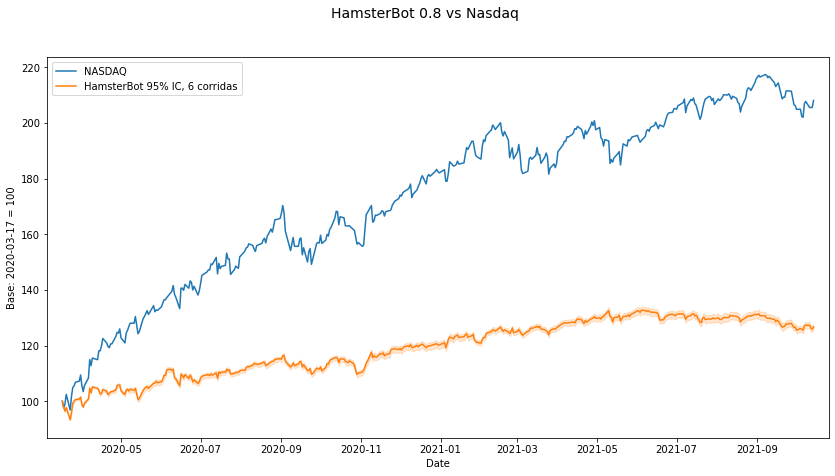

In [296]:
fig, ax01 = plt.subplots(1, 1, figsize = (14, 7))
fig.suptitle('HamsterBot 0.8 vs Nasdaq', fontsize = 14)
y_label = 'Base: ' + start_date + ' = 100'
legend_label = 'HamsterBot 95% IC, ' + str(runs) + ' corridas'
ax01.set_ylabel(y_label)
ax01.margins(x = 0.02)
# Cuando haya muchas corridas, mostrar el CI del modelo verrsus el NASDAQ
sns.lineplot(data = data_NASDAQ_escalado);
sns.lineplot(data = data_portfolio_escalado, x = data_portfolio_escalado.index, y = data_portfolio_escalado['value'], estimator = 'mean', ci = 95, label = legend_label);
plt.legend(loc = 'upper left');